# Sketching Out Plot Ideas 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import random
import os
import numpy as np


SMALL_SIZE=12
MEDIUM_SIZE=16


# TICK_SIZE = 12
# LABEL_PAD = 4
# plt.rc('axes', labelsize=18)
# plt.rc('xtick', labelsize=TICK_SIZE) 
# plt.rc('ytick', labelsize=TICK_SIZE) 
# plt.rc('label')
# plt.style.use(["seaborn-paper"])
# plt.rc('font', family='serif')
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


### Comparing Test $R^2$ values among the molecular property regression tasks

In [47]:
df = pd.DataFrame({"task":["Hy", "MLOGP", "MLOGP2", "PDI", "SAacc", "SAdon", "SAtot", "TPSA", "Uc", "Ui", "VvdwMG", "Vx","VVdwZAZ"], 
                   "score": [0.9643305452643575, 0.9787119425034523, 0.6802948609290353, 0.9631949076161059, 0.9770647810053213,
                            0.9842434252532304, 0.9966715762626913, 0.9970814206014291, 0.9553585682026731,
                            0.9564923035091162, 0.9945346807470723, 0.99299460323343, 0.9942985645868737 ]}).sort_values(by="score",ascending=False)

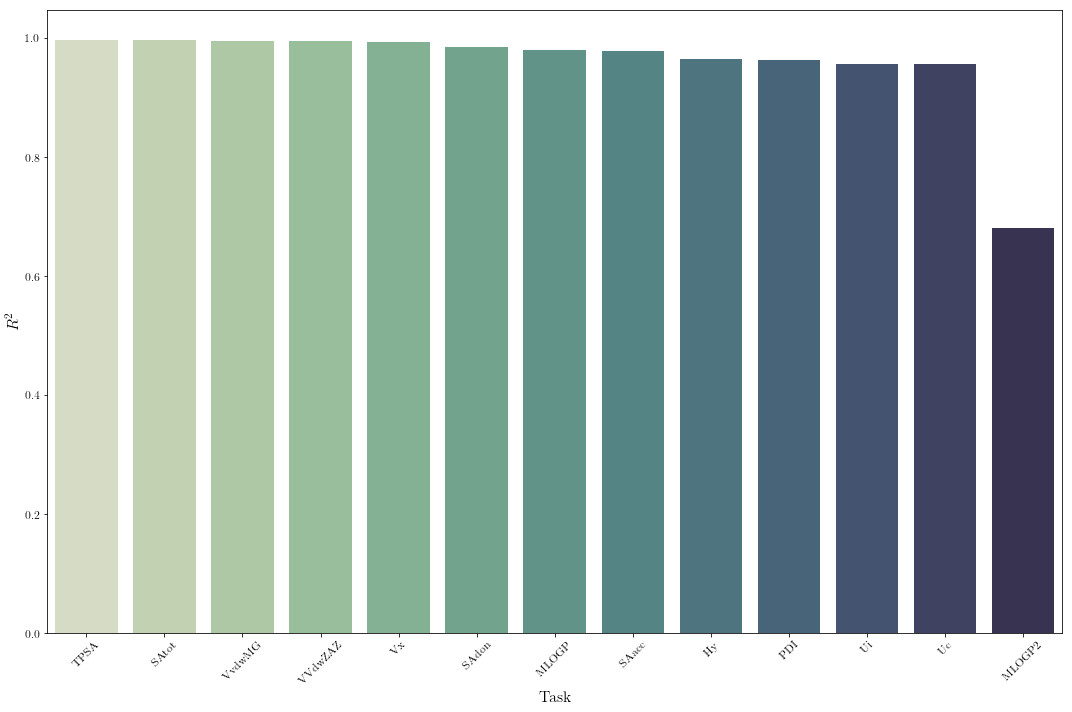

In [69]:
plt.clf()
plt.figure(figsize=(15,10))
# g = sns.barplot("task", "score", data=df, palette=sns.color_palette("hls", 15))
g = sns.barplot("task", "score", data=df, palette=sns.cubehelix_palette(14, start=.5, rot=-.75))
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_ylabel("$R^{2}$")
g.set_xlabel("Task")
plt.tight_layout()
plt.savefig('r2_per_task.png', format='png')

### Comparing Test F1-Scores (and or other metrics) versus number of processors

In [5]:
process_df = pd.read_csv("/home/derek/workspace/deep_protein_binding/results/best_model_search_test_results.csv", index_col=0)
process_df["n_process"] = process_df.path.str.split("_").apply(lambda x: x[6]).apply(lambda x: x.split("/")[0])
process_df["n_process"] = pd.to_numeric(process_df["n_process"])
process_df = process_df.sort_values(by="n_process")
process_df.head()
process_df = process_df.groupby("n_process").mean().reset_index()
process_df

,n_process,score
0,1,0.830669
1,2,0.851020
2,3,0.864519
3,4,0.866915
4,5,0.852988
5,6,0.868601
6,7,0.877444
7,8,0.864513
8,9,0.867444
9,10,0.854460


* Should I include the error bars which will show how much variance each point has associated with it? Does the confidence interval properly capture this?

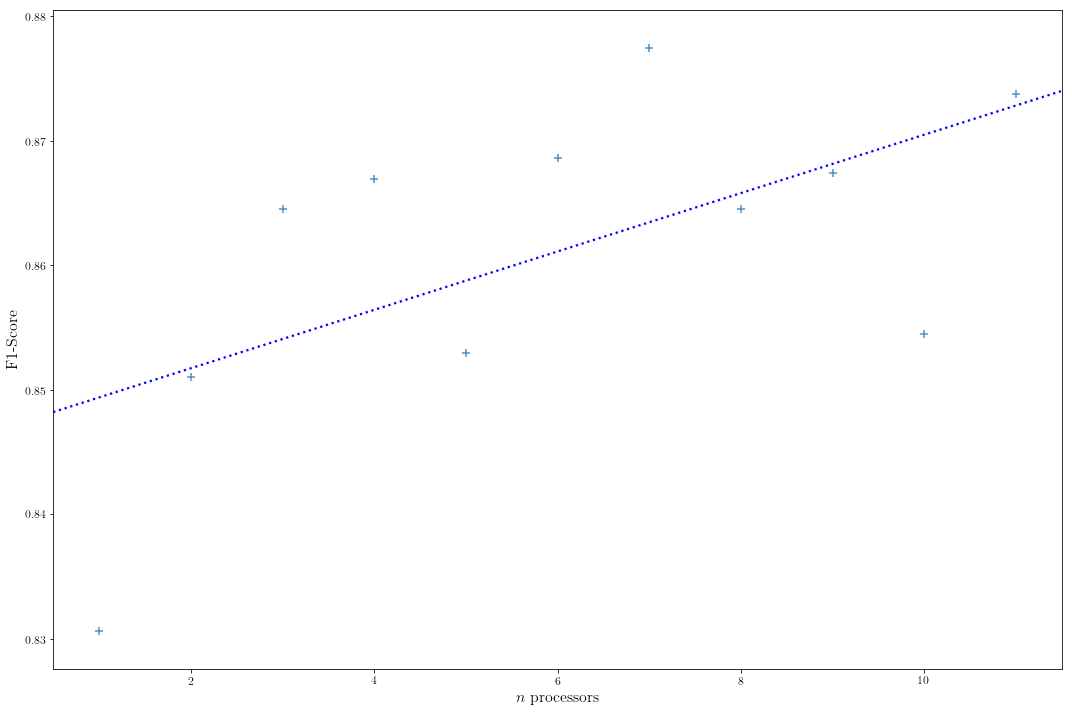

In [28]:
plt.clf()
plt.figure(figsize=(15,10))
g = sns.regplot(x="n_process", y="score", data=process_df, marker="+", 
            line_kws={'color':'blue', "linestyle": ":"}, scatter_kws={"s":60}, ci=None)
g.set_xlabel("$n$ processors")
g.set_ylabel("F1-Score")
plt.tight_layout()
plt.savefig('f1_vs_processors.png', format='png')

## Get the best model and then plot roc and confusion

In [7]:
best_df = None
best_model_path = "/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82670_epoch4"

for file in os.listdir(best_model_path):
    if "confusion" not in file:
        best_df = pd.concat([best_df, pd.read_csv(best_model_path+"/"+file, index_col=0)])

y_true = best_df.true.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
y_pred = best_df.pred.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))

y_score = best_df.pred.apply(lambda x: np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)[1])


## ROC Curve

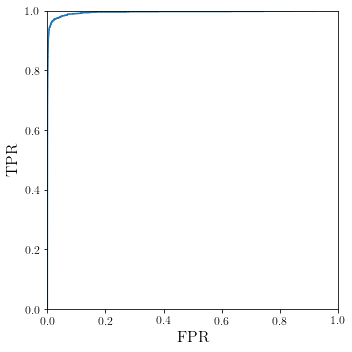

In [8]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_score=y_score, y_true=y_true)


plt.clf()
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()
plt.show()

## Confusion Matrix

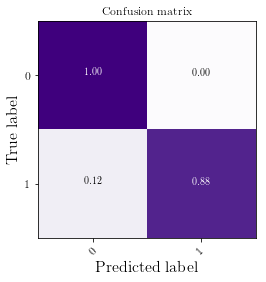

In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
from sklearn.metrics import confusion_matrix
           
cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
plt.clf()
# plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=[0,1], normalize=True, cmap=plt.cm.Purples)


## now make the confusion matrix for all of the best models

11it [00:08,  1.23it/s]


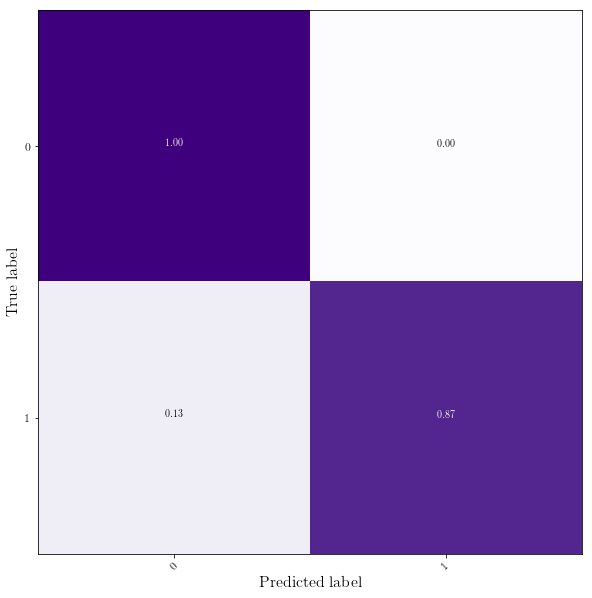

In [10]:
from tqdm import tqdm 
best_result_df = pd.read_csv("/home/derek/workspace/deep_protein_binding/results/best_model_search_max_f1_score_models.csv", index_col=0)
for idx, path in tqdm(enumerate(best_result_df.path)):
    path = path.replace("/scratch/wdjo224", "/home/derek/workspace")
    df = None
    for file in os.listdir(path):
        if "confusion" not in file:
            df = pd.concat([df, pd.read_csv("{}/{}".format(path,file),index_col=0)])
        else:
            os.system("rm {}/{}".format(path,file))
    y_true = df.true.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
    y_pred = df.pred.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    plt.clf()
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(cm, classes=[0,1], title="", normalize=True, cmap=plt.cm.Purples)
    plt.savefig("{}/confusion_{}.png".format(path, idx+1), format="png")

## make the roc for all of the models

11it [00:06,  1.72it/s]


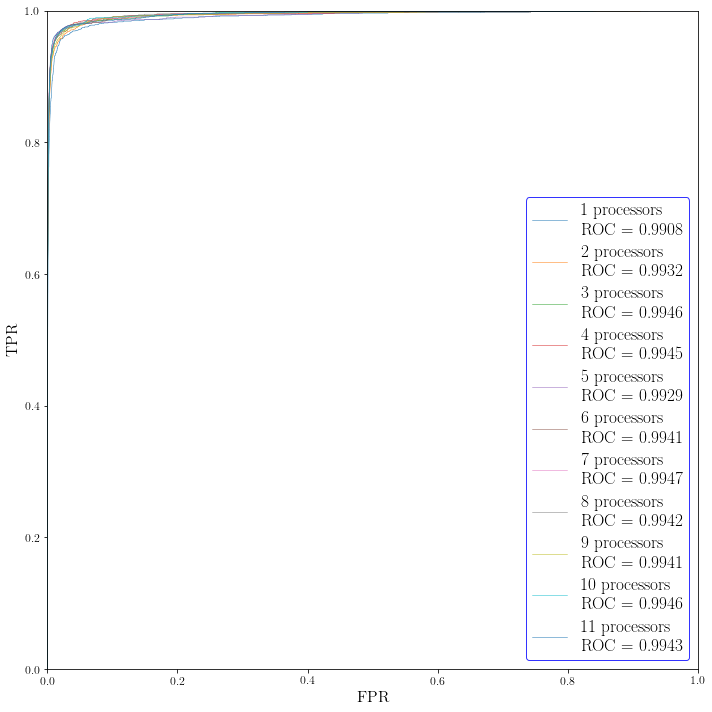

In [11]:
from tqdm import tqdm 
from sklearn.metrics import roc_auc_score

best_result_df = pd.read_csv("/home/derek/workspace/deep_protein_binding/results/best_model_search_max_f1_score_models.csv", index_col=0)
plt.clf()
plt.figure(figsize=(10,10))

for idx, path in tqdm(enumerate(best_result_df.path)):
    path = path.replace("/scratch/wdjo224", "/home/derek/workspace")
    df = None
    for file in os.listdir(path):
        if "confusion" not in file:
            df = pd.concat([df, pd.read_csv("{}/{}".format(path,file),index_col=0)])
        else:
            os.system("rm {}/{}".format(path,file))
    y_true = df.true.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
    y_score = df.pred.apply(lambda x: np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)[1])
    fpr, tpr, _ = roc_curve(y_score=y_score, y_true=y_true, pos_label=1)
    roc_score = roc_auc_score(y_score=y_score, y_true=y_true)

    plt.plot(fpr,tpr, label="{} processors \n ROC = {:.4f}".format(idx+1, roc_score), linewidth=0.5)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
l = plt.legend(loc="lower right", fontsize="xx-large", fancybox=True)
l.get_frame().set_edgecolor('b')

plt.savefig("/home/derek/workspace/deep_protein_binding/results/best_model_search_roc.png", format="png")

# instead of searching for the best model, just use the mean of their predictions?

  0%|          | 0/11 [00:00<?, ?it/s]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_7/test_results/p117926_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_7/test_results/p117924_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_7/test_results/p117925_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_7/test_results/p117921_epoch4


  9%|▉         | 1/11 [00:02<00:26,  2.65s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82670_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82669_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82665_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82668_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82664_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82663_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82666_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8/test_results/p82667_epoch4


 18%|█▊        | 2/11 [00:07<00:35,  3.93s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_3/test_results/p7550_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_3/test_results/p7548_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_3/test_results/p7549_epoch4


 27%|██▋       | 3/11 [00:09<00:26,  3.30s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_6/test_results/p118206_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_6/test_results/p118204_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_6/test_results/p118201_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_6/test_results/p118205_epoch4


 36%|███▋      | 4/11 [00:12<00:22,  3.16s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6086_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6087_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6083_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6084_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6090_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6088_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_9/test_results/p6082_epoch4


 45%|████▌     | 5/11 [00:17<00:20,  3.43s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_2/test_results/p30309_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_2/test_results/p30308_epoch4


 55%|█████▍    | 6/11 [00:18<00:15,  3.09s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_11/test_results/p9940_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_11/test_results/p9947_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_11/test_results/p9945_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_11/test_results/p9949_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_11/test_results/p9943_epoch4


 64%|██████▎   | 7/11 [00:21<00:12,  3.11s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_5/test_results/p28635_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_5/test_results/p28637_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_5/test_results/p28634_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_5/test_results/p28636_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_5/test_results/p28633_epoch4


 73%|███████▎  | 8/11 [00:25<00:09,  3.13s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_10/test_results/p123667_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_10/test_results/p123664_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_10/test_results/p123668_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_10/test_results/p123670_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_10/test_results/p123666_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_10/test_results/p123669_epoch4


 82%|████████▏ | 9/11 [00:28<00:06,  3.21s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:39:59_1/test_results/p86268_epoch4


 91%|█████████ | 10/11 [00:29<00:02,  2.97s/it]

/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_4/test_results/p92824_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_4/test_results/p92823_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_4/test_results/p92825_epoch4
/home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_4/test_results/p92826_epoch4


100%|██████████| 11/11 [00:32<00:00,  2.94s/it]


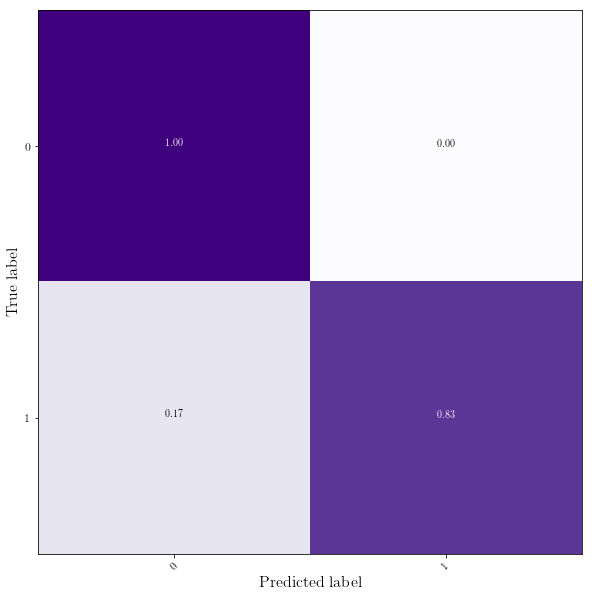

In [45]:
import glob

dirs = glob.glob("/home/derek/workspace/deep_protein_binding/experiments/best_model_search_*")
for dir in tqdm(dirs):
    epoch_list = os.listdir(dir+"/test_results/")
    epoch_cm = np.zeros([2,2])
    n_process = dir.split("_")[-1]
    for epoch in epoch_list:
        epoch_df = pd.DataFrame()
        epoch_path = "{}/test_results/{}".format(dir,epoch)
        print(epoch_path)
        for file in os.listdir(epoch_path):
            epoch_df = pd.concat([epoch_df, pd.read_csv("{}/{}".format(epoch_path,file), index_col=0)])
        y_true = epoch_df.true.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
        y_pred = epoch_df.pred.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
        cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
        epoch_cm += cm
    epoch_cm = epoch_cm/len(epoch_path)
    plt.clf()
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(epoch_cm, classes=[0,1], title="", normalize=True, cmap=plt.cm.Purples)
    plt.savefig("{}/mean_confusion_{}.png".format(dir, n_process), format="png")

 # Get the average classification reports?

In [63]:
from sklearn.metrics import precision_recall_fscore_support
dirs = glob.glob("/home/derek/workspace/deep_protein_binding/experiments/best_model_search_*")
for idx, dir in enumerate(dirs):
    epoch_list = os.listdir(dir+"/test_results/")
    epoch_prec, epoch_rec, epoch_f1 = 0, 0, 0
    print("{:=^50}".format(' {} ').format(dir))
    for epoch in epoch_list:
        epoch_df = pd.DataFrame()
        epoch_path = "{}/test_results/{}".format(dir,epoch)
        for file in os.listdir(epoch_path):
            epoch_df = pd.concat([epoch_df, pd.read_csv("{}/{}".format(epoch_path,file), index_col=0)])
        y_true = epoch_df.true.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
        y_pred = epoch_df.pred.apply(lambda x: np.argmax(np.fromstring(x.strip("[ ]"), sep=" ", dtype=np.float32)))
        prec, rec, f1, _ = precision_recall_fscore_support(y_pred=y_pred, y_true=y_true)
        epoch_prec+=prec
        epoch_rec+=rec
        epoch_f1+=f1
    epoch_prec = epoch_prec/len(epoch_list)
    epoch_rec = epoch_rec/len(epoch_list)
    epoch_f1 = epoch_f1/len(epoch_list)
    print("prec: {} \t rec: {} \t f1: {}".format(epoch_prec, epoch_rec, epoch_f1))

======================= /home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_7 =======================
prec: [ 0.99642063  0.89522721] 	 rec: [ 0.99741485  0.86040398] 	 f1: [ 0.99691747  0.87744383]
======================= /home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_8 =======================
prec: [ 0.99598447  0.89043291] 	 rec: [ 0.99727636  0.84324848] 	 f1: [ 0.99662893  0.86451313]
======================= /home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_3 =======================
prec: [ 0.99536798  0.91567582] 	 rec: [ 0.99805877  0.81903708] 	 f1: [ 0.99671147  0.86451881]
======================= /home/derek/workspace/deep_protein_binding/experiments/best_model_search_19:40:03_6 =======================
prec: [ 0.99664903  0.86972719] 	 rec: [ 0.99660166  0.86939679] 	 f1: [ 0.99662457  0.86860109]
======================= /home/derek/workspace/deep_protein_binding/experiments/best_